## Load data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from scipy.stats import mannwhitneyu
import pandas as pd
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
plt.rcParams.update({'font.size': 12})

In [5]:
#import experiments
datapath = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf_new'
variable = 'surface_net_longwave_flux'

experiment1 = 'drysoil_d0198_RAL3P2_albedo_bare_' 
allvar = xr.open_dataset(f'{datapath}/{variable}/{experiment1}{variable}.nc')['surface_net_downward_longwave_flux']

experiment2 = 'control_d0198_RAL3P2_' 
control = xr.open_dataset(f'{datapath}/{variable}/{experiment2}{variable}.nc')['surface_net_downward_longwave_flux']

experiment3 = 'control_d0198_RAL3P2_albedo_bare_'
albedo_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment3}{variable}.nc')['surface_net_downward_longwave_flux']

experiment4 = 'control_d0198_RAL3P2_albedo_'
albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment4}{variable}.nc')['surface_net_downward_longwave_flux']

experiment5 = 'control_d0198_RAL3P2_bare_'
bare = xr.open_dataset(f'{datapath}/{variable}/{experiment5}{variable}.nc')['surface_net_downward_longwave_flux']

experiment6 = 'drysoil_d0198_RAL3P2_albedo_'
SM_albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment6}{variable}.nc')['surface_net_downward_longwave_flux']

experiment7 = 'drysoil_d0198_RAL3P2_bare_'
SM_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment7}{variable}.nc')['surface_net_downward_longwave_flux']

experiment8 = 'drysoil_d0198_RAL3P2_'
SM = xr.open_dataset(f'{datapath}/{variable}/{experiment8}{variable}.nc')['surface_net_downward_longwave_flux']



In [7]:
#clip to land only
variable3 = 'land_sea_mask'
landmask = xr.open_dataset(f'{datapath}/{variable3}/{experiment1}{variable3}.nc')["land_binary_mask"].isel(time=0)
allvar = allvar.where(landmask == 1)
control = control.where(landmask == 1)
albedo_bare = albedo_bare.where(landmask == 1)
albedo = albedo.where(landmask == 1)
bare = bare.where(landmask == 1)
SM_albedo = SM_albedo.where(landmask == 1)
SM_bare = SM_bare.where(landmask == 1)
SM = SM.where(landmask == 1)

In [8]:
#store experiments 
experiments = {
    "All Variables": allvar,
    "Control": control,
    "Albedo + Bare": albedo_bare,
    "Albedo": albedo,
    "Bare": bare,
    "SM + Albedo": SM_albedo,
    "SM + Bare": SM_bare,
    "SM": SM
}


## daily averages, whole domain

In [9]:
##daily averages, averaged spatially for the whole domain

#daily mean
daily_mean = {}
for name, da in experiments.items():
    #resample to daily mean
    daily_mean[name] = da.resample(time="1D").mean()

#diff from ref
ref_name = "Control"
ref = daily_mean[ref_name]

diff = {}
for name, da in daily_mean.items():
    if name != ref_name:
        diff[name] = da - ref



#flatten spatially and remove Nans
daily_mean_flat = {}
for name, da in daily_mean.items():
    vals = da.values.flatten()
    daily_mean_flat[name] = vals[~np.isnan(vals)]
    
# #boxplot of LWnet distribution, 
# plt.figure(figsize=(12,6))
# plt.boxplot([daily_mean_flat[name] for name in experiments.keys()],
#             labels=experiments.keys(),
#             showfliers = False) #outliers hidden
# plt.ylabel("Surface net longwave flux (W/m²)")
# plt.title("Surface net longwave flux dist over experiments")
# plt.xticks(rotation=45)
# plt.show()



INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

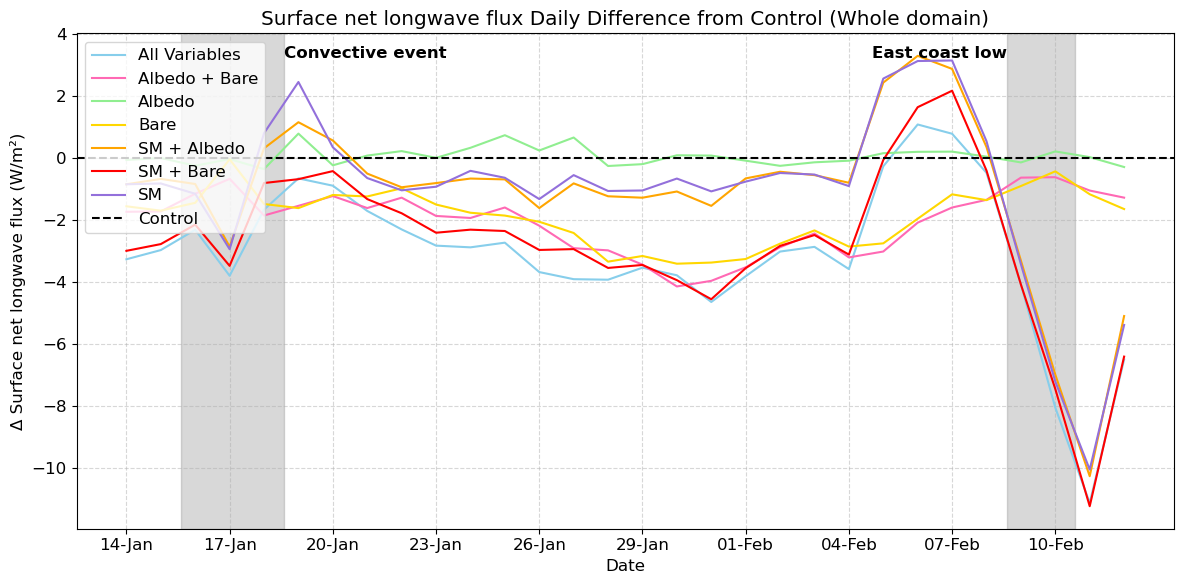

Mann-Whitney U test vs Control (p < 0.05 = significant):
All Variables vs Control: p = 0.000e+00 → Significant
Albedo + Bare vs Control: p = 0.000e+00 → Significant
Albedo vs Control: p = 1.162e-01 → Not significant
Bare vs Control: p = 0.000e+00 → Significant
SM + Albedo vs Control: p = 0.000e+00 → Significant
SM + Bare vs Control: p = 0.000e+00 → Significant
SM vs Control: p = 0.000e+00 → Significant


In [10]:
#plot difference from the control reference
ref_name = "Control"
colors = ["skyblue", "hotpink", "lightgreen", "gold", "orange", "red", "mediumpurple", "pink"]

plt.figure(figsize=(12,6))

for i, (name, da) in enumerate(diff.items()):
    #spatial mean for each day
    time_series = da.mean(dim=["latitude","longitude"], skipna=True)
    time_series = time_series.assign_coords(time=time_series.time + pd.Timedelta(hours=10)) #shift to AEST
    plt.plot(time_series.time, time_series, label=name, color=colors[i % len(colors)])

#plot grey area around the two events
start_highlight1 = pd.to_datetime("2020-02-09")  
end_highlight1   = pd.to_datetime("2020-02-11")
plt.axvspan(start_highlight1, end_highlight1, color="grey", alpha=0.3)
plt.text(start_highlight1, plt.ylim()[1]*0.9, "East coast low",
         rotation=0, va="top", ha="right", fontsize=12, color="black", weight='demi')

start_highlight2 = pd.to_datetime("2020-01-16") 
end_highlight2   = pd.to_datetime("2020-01-19")
plt.axvspan(start_highlight2, end_highlight2, color="grey", alpha=0.3)
plt.text(end_highlight2, plt.ylim()[1]*0.9, "Convective event",
         rotation=0, va="top", ha="left", fontsize=12, color="black", weight='demi')

#plot the reference line as a control baseline where diff = 0
plt.axhline(0, color='k', linestyle='--')

plt.ylabel("Δ Surface net longwave flux (W/m²)")
plt.xlabel("Date")
plt.title(f"Surface net longwave flux Daily Difference from {ref_name} (Whole domain)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)


dates = pd.to_datetime(time_series.time.values)
plt.xticks(ticks=time_series.time.values[::max(1, len(dates)//10)],
           labels=[d.strftime("%d-%b") for d in dates[::max(1, len(dates)//10)]],
           rotation=0)
#legend for control
control_handle = mlines.Line2D([], [], color='k', linestyle='--', label="Control")


plt.legend(handles=[*plt.gca().get_legend_handles_labels()[0], control_handle], loc = 'upper left')
plt.tight_layout()
plt.show()

print("Mann-Whitney U test vs Control (p < 0.05 = significant):")
for name, vals in daily_mean_flat.items():
    if name != ref_name:
        stat, p = mannwhitneyu(daily_mean_flat[ref_name], vals)
        sig_text = "Significant" if p < 0.05 else "Not significant"
        print(f"{name} vs {ref_name}: p = {p:.3e} → {sig_text}")


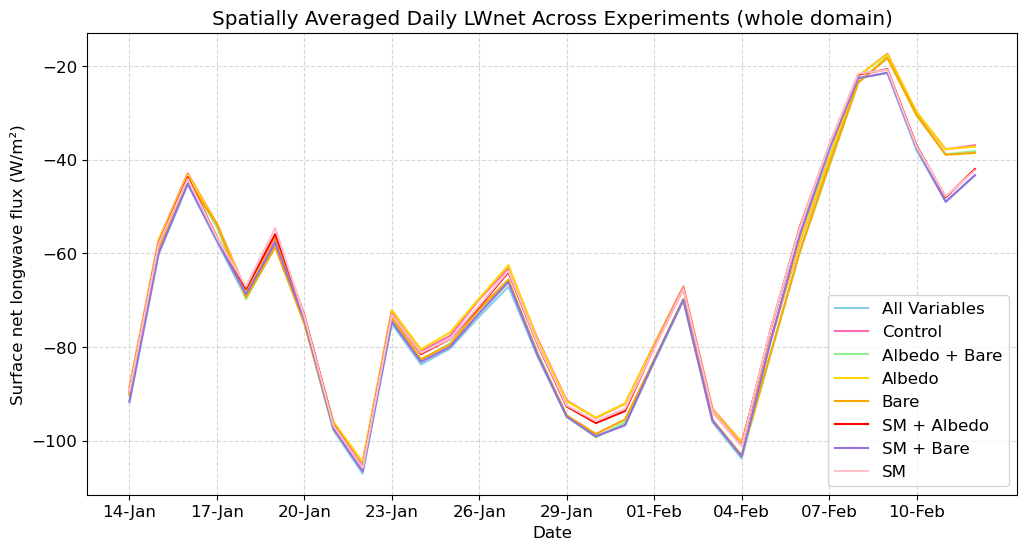

In [11]:
#daily SWnet, whole domain
plt.figure(figsize=(12,6))
colors = ["skyblue", "hotpink", "lightgreen", "gold", "orange", "red", "mediumpurple", "pink"]
for i, (name, da) in enumerate(daily_mean.items()):
    time_series = da.mean(dim=["latitude","longitude"], skipna=True)
    plt.plot(time_series.time, time_series, label=name, 
             color=colors[i % len(colors)]
            )

plt.ylabel("Surface net longwave flux (W/m²)")
plt.xlabel("Date")
plt.grid(True, linestyle="--", alpha=0.5)
dates = pd.to_datetime(time_series.time.values)
plt.xticks(ticks=time_series.time.values[::max(1, len(dates)//10)],
           labels=[d.strftime("%d-%b") for d in dates[::max(1, len(dates)//10)]],
           rotation=0)
plt.title("Spatially Averaged Daily LWnet Across Experiments (whole domain)")
plt.legend()
plt.show()

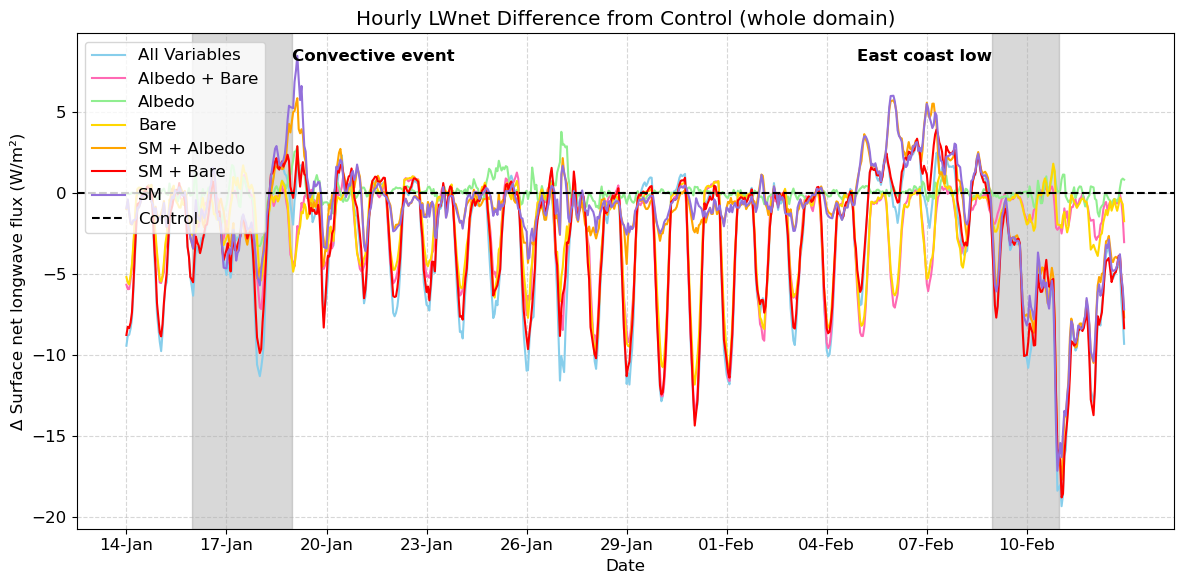

In [12]:
#hourly SWnet diff from control 
ref_name = "Control"
ref = experiments[ref_name]

#differences from control
diff_hourly = {}
for name, da in experiments.items():
    if name != ref_name:
        diff_hourly[name] = da - ref

colors = ["skyblue", "hotpink", "lightgreen", "gold", "orange", "red", "mediumpurple", "pink"]

plt.figure(figsize=(12,6))

for i, (name, da) in enumerate(diff_hourly.items()):
    time_series = da.mean(dim=["latitude","longitude"], skipna=True)
    time_series = time_series.assign_coords(time=time_series.time + pd.Timedelta(hours=10)) #AEST shift
    plt.plot(time_series.time, time_series, label=name, color=colors[i % len(colors)])

#highlight events
plt.axvspan(pd.to_datetime("2020-02-09 00:00") + pd.Timedelta(hours=10),
            pd.to_datetime("2020-02-10 23:59") + pd.Timedelta(hours=10),
            color="grey", alpha=0.3)
plt.text(pd.to_datetime("2020-02-09 00:00") + pd.Timedelta(hours=10),
         plt.ylim()[1]*0.9, "East coast low", va="top", ha="right", fontsize=12, color="black", weight='demi')

plt.axvspan(pd.to_datetime("2020-01-16 00:00") + pd.Timedelta(hours=10),
            pd.to_datetime("2020-01-18 23:59") + pd.Timedelta(hours=10),
            color="grey", alpha=0.3)
plt.text(pd.to_datetime("2020-01-18 23:59") + pd.Timedelta(hours=10),
         plt.ylim()[1]*0.9, "Convective event", va="top", ha="left", fontsize=12, color="black", weight='demi')

#baseline line + put on legend
plt.axhline(0, color='k', linestyle='--')
control_handle = mlines.Line2D([], [], color='k', linestyle='--', label="Control")
plt.grid(True, linestyle="--", alpha=0.5)


plt.ylabel("Δ Surface net longwave flux (W/m²)")
plt.xlabel("Date")
plt.title(f"Hourly LWnet Difference from {ref_name} (whole domain)")
plt.legend(handles=[*plt.gca().get_legend_handles_labels()[0], control_handle], loc="upper left")

dates = pd.to_datetime(time_series.time.values)
plt.xticks(ticks=time_series.time.values[::max(1, len(dates)//10)],
           labels=[d.strftime("%d-%b") for d in dates[::max(1, len(dates)//10)]],
           rotation=0)

plt.tight_layout()
plt.show()


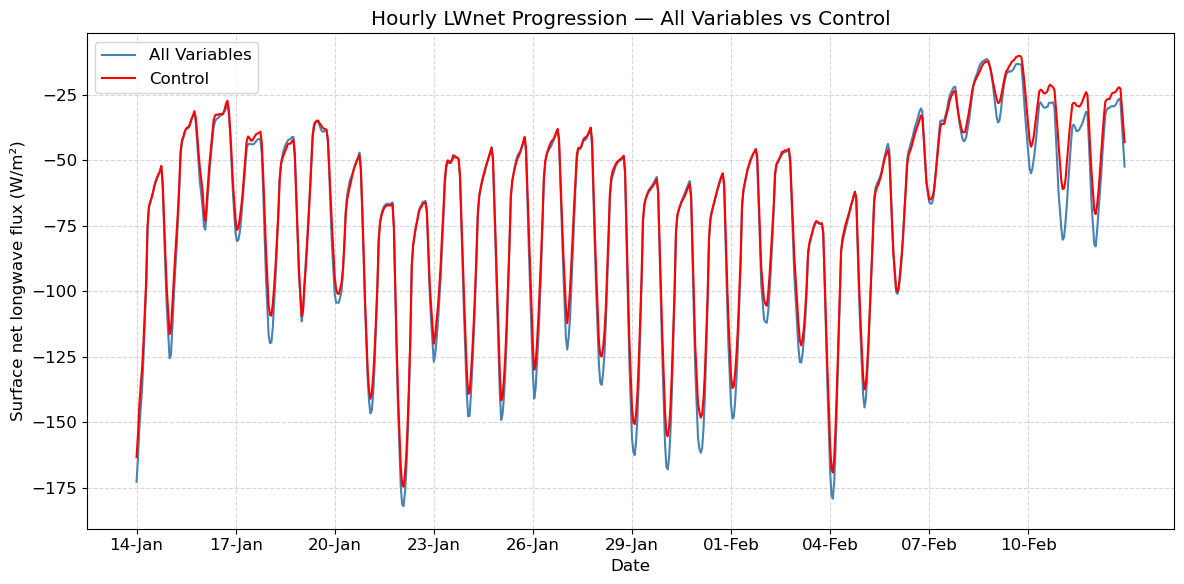

In [13]:
#demo two experiments together
exp_name = "All Variables" #can change to see diff ones 
da = experiments[exp_name]

control_name = "Control"
control_da = experiments[control_name]

time_series = da.mean(dim=["latitude","longitude"], skipna=True)
time_series = time_series.assign_coords(time=time_series.time + pd.Timedelta(hours=10)) #AEST shift

control_series = control_da.mean(dim=["latitude","longitude"], skipna=True)
control_series = control_series.assign_coords(time=control_series.time + pd.Timedelta(hours=10)) #AEST shift

plt.figure(figsize=(12,6))
plt.plot(time_series.time, time_series, label=exp_name, color="steelblue") 
plt.plot(control_series.time, control_series, label=control_name, color="red")

plt.ylabel("Surface net longwave flux (W/m²)")
plt.xlabel("Date")
plt.title(f"Hourly LWnet Progression — {exp_name} vs {control_name}")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

#format xticks
dates =pd.to_datetime(time_series.time.values)
plt.xticks(ticks=time_series.time.values[::max(1, len(dates)//10)],
           labels=[d.strftime("%d-%b") for d in dates[::max(1, len(dates)//10)]],
           rotation=0)


plt.tight_layout()
plt.show()


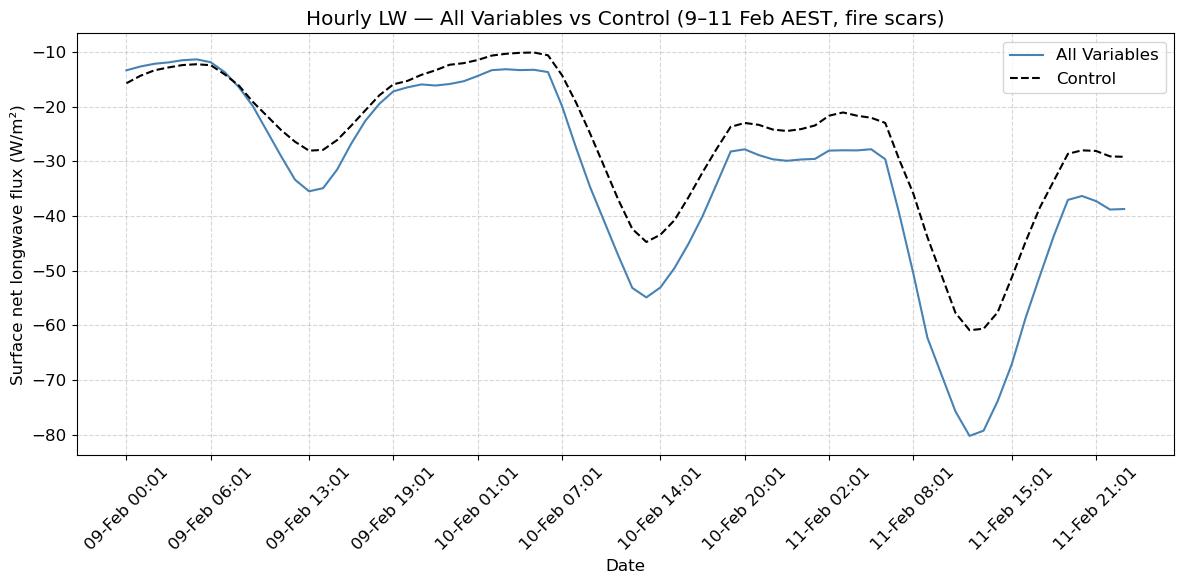

In [14]:
#zoom in on feb event
exp_name = "All Variables"
da = experiments[exp_name]

control_name = "Control"
control_da = experiments[control_name]

#spatial mean
time_series = da.mean(dim=["latitude","longitude"], skipna=True)
control_series = control_da.mean(dim=["latitude","longitude"], skipna=True)

#AEST shift
time_series = time_series.assign_coords(time=time_series.time + pd.Timedelta(hours=10))
control_series = control_series.assign_coords(time=control_series.time + pd.Timedelta(hours=10)) 

#select dates
start_date = pd.to_datetime("2020-02-09 00:00")
end_date   = pd.to_datetime("2020-02-11 23:59")


mask = (time_series.time >= start_date) & (time_series.time <= end_date)
time_series_window = time_series[mask]
dates_window = time_series_window.time.values

control_mask = (control_series.time >= start_date) & (control_series.time <= end_date)
control_series_window = control_series[control_mask]
control_dates_window = control_series_window.time.values


#plt
plt.figure(figsize=(12,6))
plt.plot(dates_window, time_series_window, label=exp_name, color="steelblue")
plt.plot(control_dates_window, control_series_window, label=control_name, color="k", linestyle="--")

plt.ylabel("Surface net longwave flux (W/m²)")
plt.xlabel("Date")
plt.title(f"Hourly LW — {exp_name} vs {control_name} (9–11 Feb AEST, fire scars)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.xticks(
    ticks=dates_window[::max(1, len(dates_window)//10)],
    labels=[pd.to_datetime(d).strftime("%d-%b %H:%M") for d in dates_window[::max(1, len(dates_window)//10)]],
    rotation=45
)

plt.tight_layout()
plt.show()

## Fire scars- daily and hourly averages 

In [15]:
fires = gpd.read_file('/g/data/ng72/as9583/merged_fires.gpkg')
variable2 = 'surface_altitude'
sa1 = xr.open_dataset(f'{datapath}/{variable2}/{experiment1}{variable2}.nc')[variable2].isel(time=0)

In [16]:
#clip data to within the fire scars
fires = fires.to_crs("EPSG:7844")

clipped = {}

for name, da in experiments.items():
    da = da.rio.write_crs("EPSG:7844")
    
    clipped_da = da.rio.clip(fires.geometry, fires.crs, drop=True, invert=False)
    
    clipped[name] = clipped_da


In [17]:
#new data
allvar = clipped['All Variables']
control =clipped['Control']
albedo_bare =clipped['Albedo + Bare']
albedo =clipped['Albedo']
bare =clipped['Bare']
SM_albedo =clipped['SM + Albedo']
SM_bare=clipped['SM + Bare']
SM =clipped['SM']

#new dictionary for clipped
experiments1 = {
    "All Variables": allvar,
    "Control": control,
    "Albedo + Bare": albedo_bare,
    "Albedo": albedo,
    "Bare": bare,
    "SM + Albedo": SM_albedo,
    "SM + Bare": SM_bare,
    "SM": SM
}

In [18]:
#daily mean
daily_mean1 = {}
for name, da in experiments1.items():
    daily_mean1[name] = da.resample(time="1D").mean()

#diff from ref
ref_name1 = "Control"
ref1 = daily_mean1[ref_name1]

diff1 = {}
for name, da in daily_mean1.items():
    if name != ref_name1:
        diff1[name] = da - ref1


#flatten for box plot if needed, also for mann whitney u test
daily_mean_flat1 = {}
for name, da in daily_mean1.items():
    vals1 = da.values.flatten() #flatten spatially
    daily_mean_flat1[name] = vals1[~np.isnan(vals1)] #remove Nan 

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

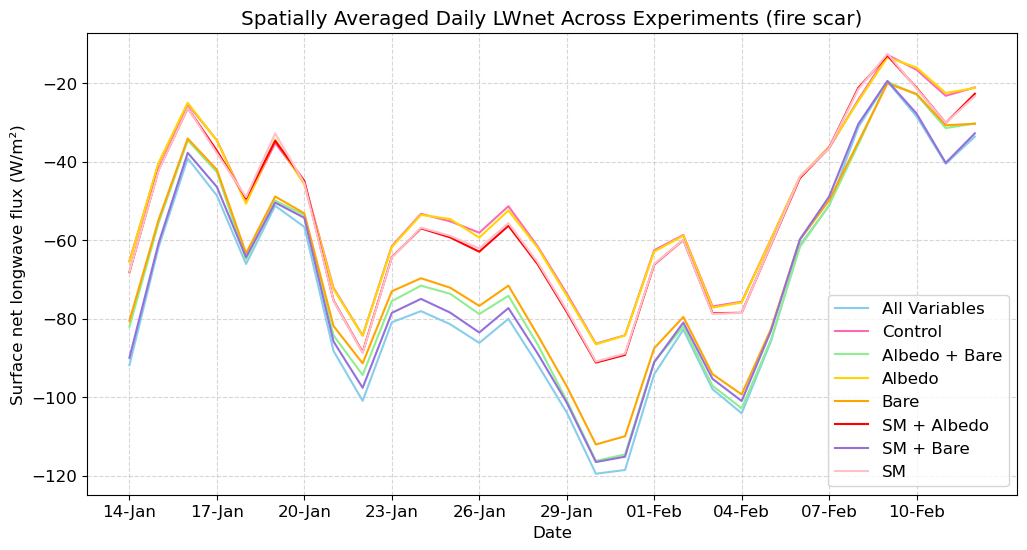

In [19]:
#daily SWnet, whole domain
plt.figure(figsize=(12,6))
colors = ["skyblue", "hotpink", "lightgreen", "gold", "orange", "red", "mediumpurple", "pink"]
for i, (name, da) in enumerate(daily_mean1.items()):
    time_series = da.mean(dim=["latitude","longitude"], skipna=True)
    plt.plot(time_series.time, time_series, label=name, 
             color=colors[i % len(colors)]
            )

plt.ylabel("Surface net longwave flux (W/m²)")
plt.xlabel("Date")
dates = pd.to_datetime(time_series.time.values)
plt.xticks(ticks=time_series.time.values[::max(1, len(dates)//10)],
           labels=[d.strftime("%d-%b") for d in dates[::max(1, len(dates)//10)]],
           rotation=0)
plt.grid(True, linestyle="--", alpha=0.5)
plt.title("Spatially Averaged Daily LWnet Across Experiments (fire scar)")
plt.legend()
plt.show()

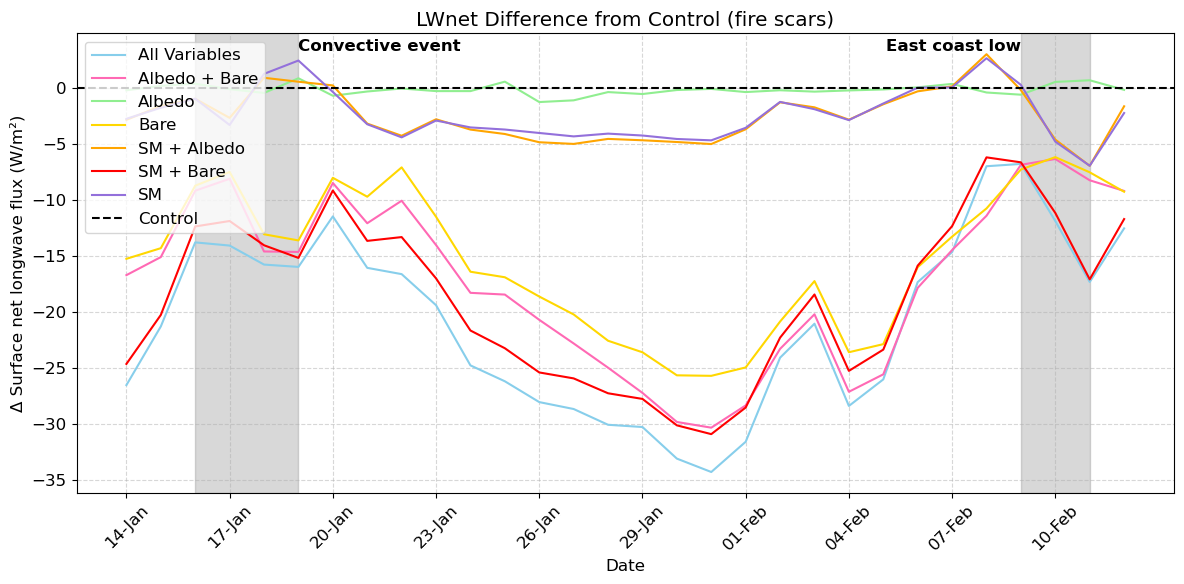

Mann-Whitney U test vs Control (p < 0.05 = significant):
All Variables vs Control: p = 0.000e+00 → Significant
Albedo + Bare vs Control: p = 0.000e+00 → Significant
Albedo vs Control: p = 1.172e-01 → Not significant
Bare vs Control: p = 0.000e+00 → Significant
SM + Albedo vs Control: p = 1.723e-252 → Significant
SM + Bare vs Control: p = 0.000e+00 → Significant
SM vs Control: p = 3.724e-230 → Significant


In [20]:
ref_name1 = "Control"
colors = ["skyblue", "hotpink", "lightgreen", "gold", "orange", "red", "mediumpurple", "pink"]

plt.figure(figsize=(12,6))

for i, (name, da) in enumerate(diff1.items()):
    time_series = da.mean(dim=["latitude","longitude"], skipna=True) #spatial mean over day
    # time_series = time_series.isel(time=slice(None, -1)) #cut off last data point
    time_series = time_series.assign_coords(time=time_series.time + pd.Timedelta(hours=10)) #shift to AEST
    plt.plot(time_series.time, time_series, label=name, color=colors[i % len(colors)])


#shade grey areas where events were
plt.axvspan(pd.to_datetime("2020-02-09 00:00") + pd.Timedelta(hours=10),
            pd.to_datetime("2020-02-10 23:59") + pd.Timedelta(hours=10),
            color="grey", alpha=0.3)
plt.text(pd.to_datetime("2020-02-09 00:00") + pd.Timedelta(hours=10),
         plt.ylim()[1]*0.9, "East coast low", va="top", ha="right", fontsize=12, color="black", weight='demi')

plt.axvspan(pd.to_datetime("2020-01-16 00:00") + pd.Timedelta(hours=10),
            pd.to_datetime("2020-01-18 23:59") + pd.Timedelta(hours=10),
            color="grey", alpha=0.3)
plt.text(pd.to_datetime("2020-01-18 23:59") + pd.Timedelta(hours=10),
         plt.ylim()[1]*0.9, "Convective event", va="top", ha="left", fontsize=12, color="black", weight='demi')


#plot control baseline where diff = 0
plt.axhline(0, color='k', linestyle='--')


plt.ylabel("Δ Surface net longwave flux (W/m²)")
plt.xlabel("Date")
plt.title(f"LWnet Difference from {ref_name} (fire scars)")
plt.legend()

dates = pd.to_datetime(time_series.time.values)
plt.xticks(ticks=time_series.time.values[::max(1, len(dates)//10)],
           labels=[d.strftime("%d-%b") for d in dates[::max(1, len(dates)//10)]],
           rotation=45)
#make a custom legend entry for the control proxy 
control_handle = mlines.Line2D([], [], color='k', linestyle='--', label="Control")
plt.grid(True, linestyle="--", alpha=0.5)

plt.legend(handles=[*plt.gca().get_legend_handles_labels()[0], control_handle], loc = 'upper left')
plt.tight_layout()
plt.show()

print("Mann-Whitney U test vs Control (p < 0.05 = significant):")
for name, vals in daily_mean_flat1.items():
    if name != ref_name:
        stat, p = mannwhitneyu(daily_mean_flat1[ref_name], vals)
        sig_text = "Significant" if p < 0.05 else "Not significant"
        print(f"{name} vs {ref_name}: p = {p:.3e} → {sig_text}")

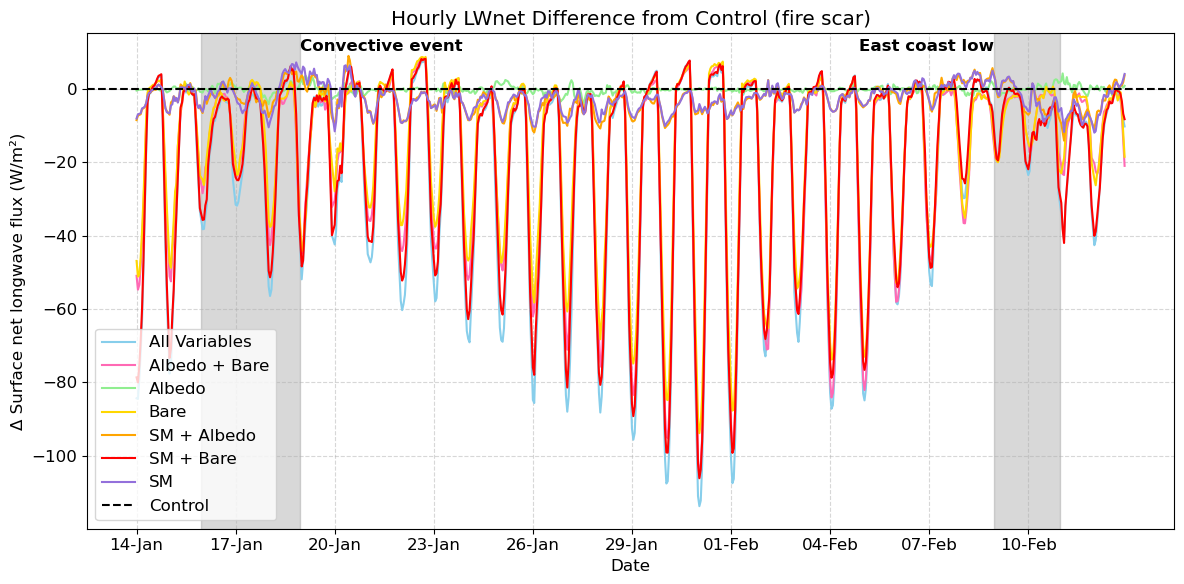

In [21]:
#hourly SWnet diff from control
ref_name = "Control"
ref1 = experiments1[ref_name]

#differences from control
diff_hourly = {}
for name, da in experiments1.items():
    if name != ref_name:
        diff_hourly[name] = da - ref1

colors = ["skyblue", "hotpink", "lightgreen", "gold", "orange", "red", "mediumpurple", "pink"]

plt.figure(figsize=(12,6))

for i, (name, da) in enumerate(diff_hourly.items()):
    #spatial mean at each hour
    time_series = da.mean(dim=["latitude","longitude"], skipna=True)
    time_series = time_series.assign_coords(time=time_series.time + pd.Timedelta(hours=10)) #AEST shift
    plt.plot(time_series.time, time_series, label=name, color=colors[i % len(colors)])

#highlight events
plt.axvspan(pd.to_datetime("2020-02-09 00:00") + pd.Timedelta(hours=10),
            pd.to_datetime("2020-02-10 23:59") + pd.Timedelta(hours=10),
            color="grey", alpha=0.3)
plt.text(pd.to_datetime("2020-02-09 00:00") + pd.Timedelta(hours=10),
         plt.ylim()[1]*0.9, "East coast low", va="top", ha="right", fontsize=12, color="black", weight='demi')

plt.axvspan(pd.to_datetime("2020-01-16 00:00") + pd.Timedelta(hours=10),
            pd.to_datetime("2020-01-18 23:59") + pd.Timedelta(hours=10),
            color="grey", alpha=0.3)
plt.text(pd.to_datetime("2020-01-18 23:59") + pd.Timedelta(hours=10),
         plt.ylim()[1]*0.9, "Convective event", va="top", ha="left", fontsize=12, color="black", weight='demi')

#baseline line + put on legend
plt.axhline(0, color='k', linestyle='--')
control_handle = mlines.Line2D([], [], color='k', linestyle='--', label="Control")
plt.grid(True, linestyle="--", alpha=0.5)

plt.ylabel("Δ Surface net longwave flux (W/m²)")
plt.xlabel("Date")
plt.title(f"Hourly LWnet Difference from {ref_name} (fire scar)")
plt.legend(handles=[*plt.gca().get_legend_handles_labels()[0], control_handle], loc="lower left")

dates = pd.to_datetime(time_series.time.values)
plt.xticks(ticks=time_series.time.values[::max(1, len(dates)//10)],
           labels=[d.strftime("%d-%b") for d in dates[::max(1, len(dates)//10)]],
           rotation=0)

plt.tight_layout()
plt.show()


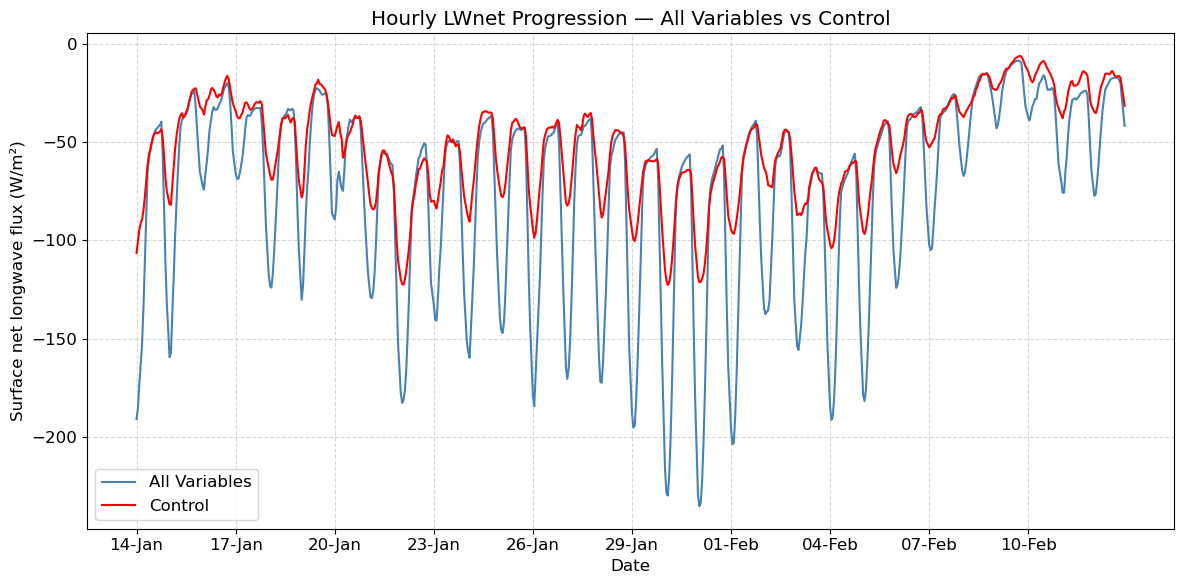

In [22]:
#demo two experiments together
exp_name = "All Variables" #can change to see diff ones 
da = experiments1[exp_name]

control_name = "Control"
control_da = experiments1[control_name]

time_series = da.mean(dim=["latitude","longitude"], skipna=True)
time_series = time_series.assign_coords(time=time_series.time + pd.Timedelta(hours=10)) #AEST shift

control_series = control_da.mean(dim=["latitude","longitude"], skipna=True)
control_series = control_series.assign_coords(time=control_series.time + pd.Timedelta(hours=10)) #AEST shift

plt.figure(figsize=(12,6))
plt.plot(time_series.time, time_series, label=exp_name, color="steelblue") 
plt.plot(control_series.time, control_series, label=control_name, color="red")

plt.ylabel("Surface net longwave flux (W/m²)")
plt.xlabel("Date")
plt.grid(True, linestyle="--", alpha=0.5)
plt.title(f"Hourly LWnet Progression — {exp_name} vs {control_name}")
plt.legend()

#format xticks
dates =pd.to_datetime(time_series.time.values)
plt.xticks(ticks=time_series.time.values[::max(1, len(dates)//10)],
           labels=[d.strftime("%d-%b") for d in dates[::max(1, len(dates)//10)]],
           rotation=0)


plt.tight_layout()
plt.show()


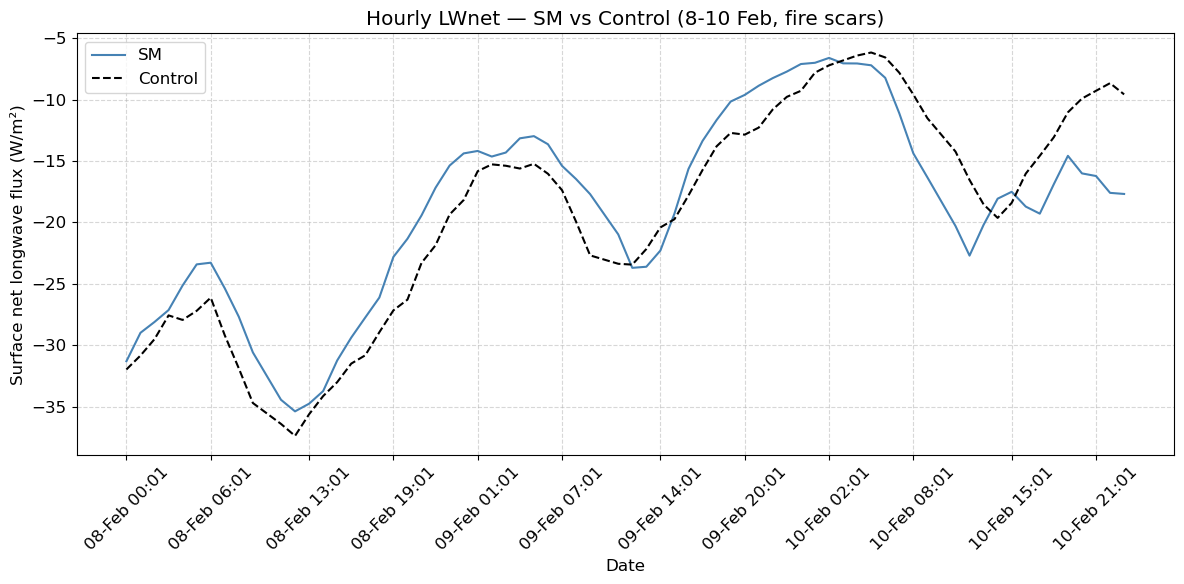

In [23]:
#zoom in on feb event
exp_name = "SM"
da = experiments1[exp_name]

control_name = "Control"
control_da = experiments1[control_name]

#spatial mean
time_series = da.mean(dim=["latitude","longitude"], skipna=True)
control_series = control_da.mean(dim=["latitude","longitude"], skipna=True)

#shift to AEST
time_series = time_series.assign_coords(time=time_series.time + pd.Timedelta(hours=10)) 
control_series = control_series.assign_coords(time=control_series.time + pd.Timedelta(hours=10)) 

#time window
start_date = pd.to_datetime("2020-02-08 00:00")
end_date   = pd.to_datetime("2020-02-10 23:59")

mask = (time_series.time >= start_date) & (time_series.time <= end_date)
time_series_window = time_series[mask]
dates_window = time_series_window.time.values

control_mask = (control_series.time >= start_date) & (control_series.time <= end_date)
control_series_window = control_series[control_mask]
control_dates_window = control_series_window.time.values


#plt
plt.figure(figsize=(12,6))
plt.plot(dates_window, time_series_window, label=exp_name, color="steelblue")
plt.plot(control_dates_window, control_series_window, label=control_name, color="k", linestyle="--")

plt.ylabel("Surface net longwave flux (W/m²)")
plt.xlabel("Date")
plt.title(f"Hourly LWnet — {exp_name} vs {control_name} (8-10 Feb, fire scars)")
plt.legend()

plt.xticks(
    ticks=dates_window[::max(1, len(dates_window)//10)],
    labels=[pd.to_datetime(d).strftime("%d-%b %H:%M") for d in dates_window[::max(1, len(dates_window)//10)]],
    rotation=45
)
plt.grid(True, linestyle="--", alpha=0.5)


plt.tight_layout()
plt.show()

# diurnal

## whole domain

In [24]:
#get diurnal cycle of whole inner domain
#spatial mean
sw_series = {}
for name, da in experiments.items():
    da = da.assign_coords(time=da.time + pd.Timedelta(hours=10))
    sw_series[name] = da.mean(dim=["latitude", "longitude"], skipna=True)

#group the time series by hour and get the mean over the dataset
sw_diurnal = {}
for name, series in sw_series.items():
    sw_diurnal[name] = series.groupby("time.hour").mean("time")


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Enteri

In [25]:
#compute diff
ref = sw_diurnal["Control"]

sw_diff = {}
for name, series in sw_diurnal.items():
    if name != "Control":
        #align on hour dimension
        series, ref_aligned = xr.align(series, ref)
        sw_diff[name] = series - ref_aligned


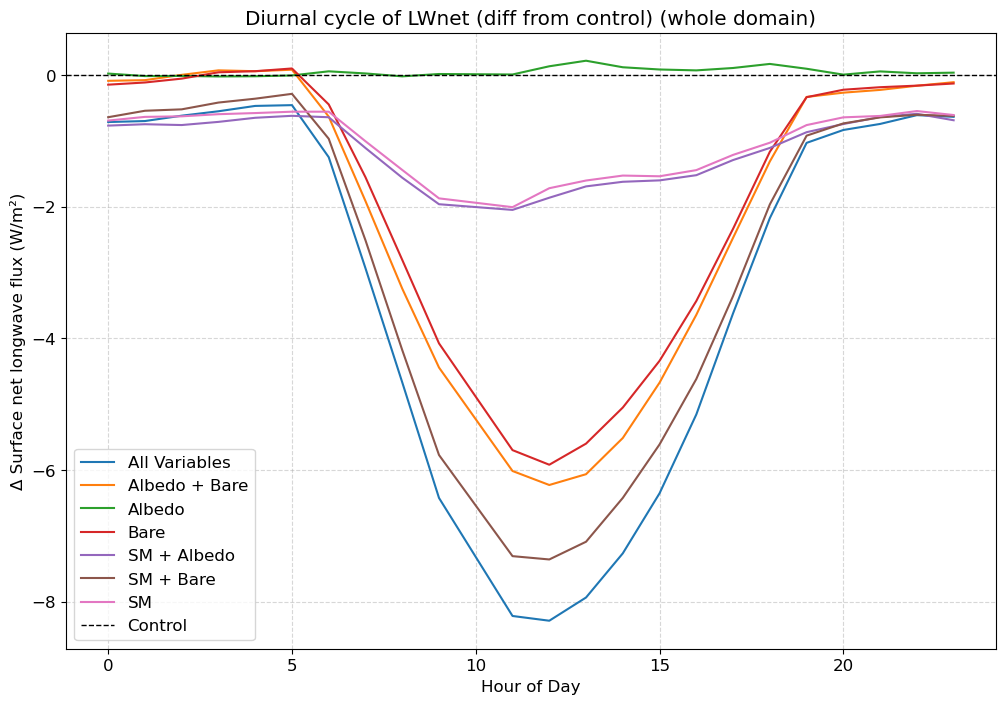

In [26]:
plt.figure(figsize=(12,8))

for name, diff in sw_diff.items():
    plt.plot(diff["hour"], diff.values, label=f"{name}")

plt.axhline(0, color="k", linestyle="--", linewidth=1, label = 'Control')
plt.title("Diurnal cycle of LWnet (diff from control) (whole domain)")
plt.xlabel("Hour of Day")
plt.ylabel("Δ Surface net longwave flux (W/m²)")
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

## fire scars

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Enteri

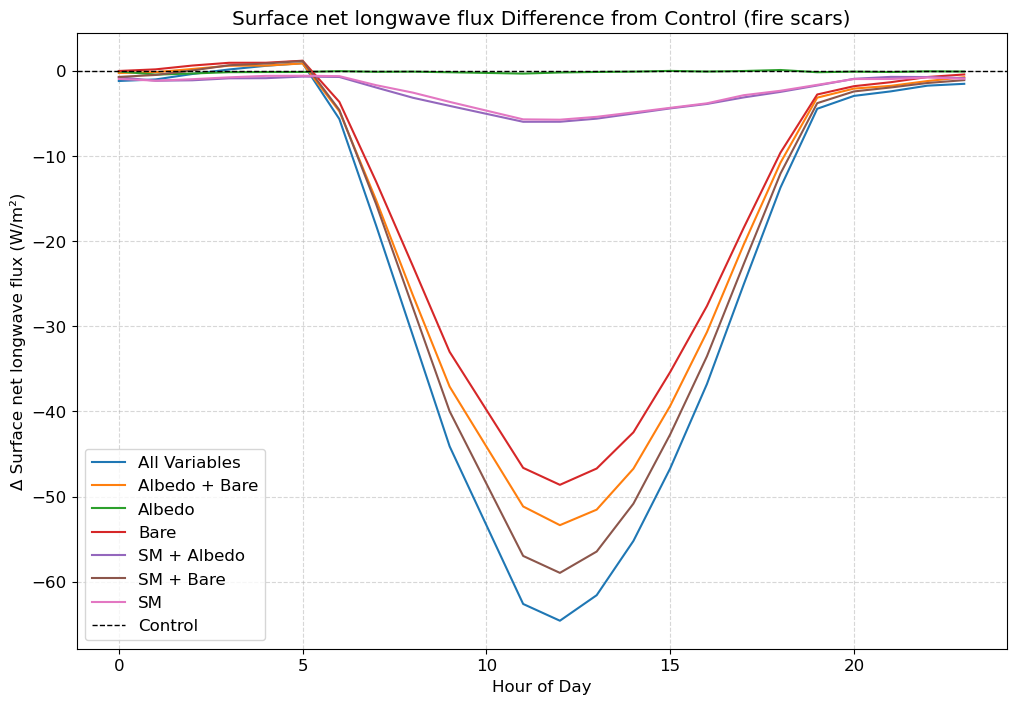

In [27]:
sw_series = {}
colors = ["skyblue", "hotpink", "lightgreen", "gold", "orange", "red", "mediumpurple", "pink"]

for name, da in experiments1.items():
    da = da.assign_coords(time=da.time + pd.Timedelta(hours=10))
    sw_series[name] = da.mean(dim=["latitude", "longitude"], skipna=True)

sw_diurnal = {}
for name, series in sw_series.items():
    sw_diurnal[name] = series.groupby("time.hour").mean("time")

ref = sw_diurnal["Control"]

sw_diff = {}
for name, series in sw_diurnal.items():
    if name != "Control":
        #align on hour dimension 
        series, ref_aligned = xr.align(series, ref)
        sw_diff[name] = series - ref_aligned

plt.figure(figsize=(12,8))


for name, diff in sw_diff.items():
    plt.plot(diff["hour"], diff.values, label=f"{name}")

plt.axhline(0, color="k", linestyle="--", linewidth=1, label = 'Control')
plt.title("Surface net longwave flux Difference from Control (fire scars)")
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Δ Surface net longwave flux (W/m²)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
# plt.savefig("/g/data/ng72/as9583/figures/lw_local.png", dpi=300, bbox_inches="tight")
plt.show()


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox' since nanquantile
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox' since nanquantile
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox' since nanquantile
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flo

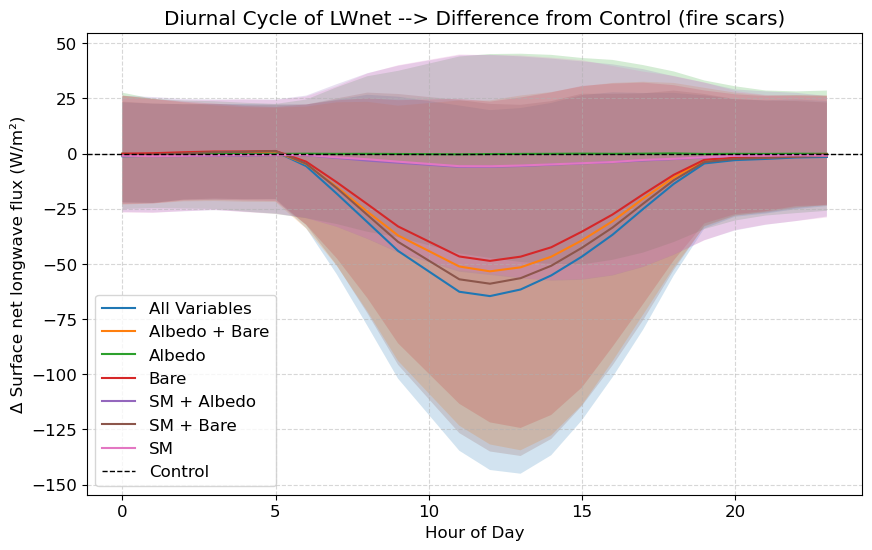

In [28]:
#show 95th and 5th percentile
sw_diurnal = {}
for name, series in sw_series.items():
    grouped = series.groupby("time.hour")
    sw_diurnal[name] = {
        "mean": grouped.mean("time"),
        "p05": grouped.quantile(0.05, dim="time"),
        "p95": grouped.quantile(0.95, dim="time"),
    }

ref = sw_diurnal["Control"]["mean"]

sw_diff = {}
for name, stats in sw_diurnal.items():
    if name != "Control":
        #align on hour dimension
        mean, ref_aligned = xr.align(stats["mean"], ref)
        p05, _ = xr.align(stats["p05"], ref)
        p95, _ = xr.align(stats["p95"], ref)

        sw_diff[name] = {
            "mean": mean - ref_aligned,
            "p05": p05 - ref_aligned,
            "p95": p95 - ref_aligned,
        }

plt.figure(figsize=(10,6))
for name, stats in sw_diff.items():
    hours = stats["mean"]["hour"]

    #mean line
    plt.plot(hours, stats["mean"].values, label=f"{name}")

    #shading for 5th–95th percentile
    plt.fill_between(
        hours,
        stats["p05"].values,
        stats["p95"].values,
        alpha=0.2
    )

plt.axhline(0, color="k", linestyle="--", linewidth=1, label = 'Control')
plt.title("Diurnal Cycle of LWnet --> Difference from Control (fire scars)")
plt.xlabel("Hour of Day")
plt.ylabel("Δ Surface net longwave flux (W/m²)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox' since nanquantile
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox' since nanquantile
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox' since nanquantile
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flo

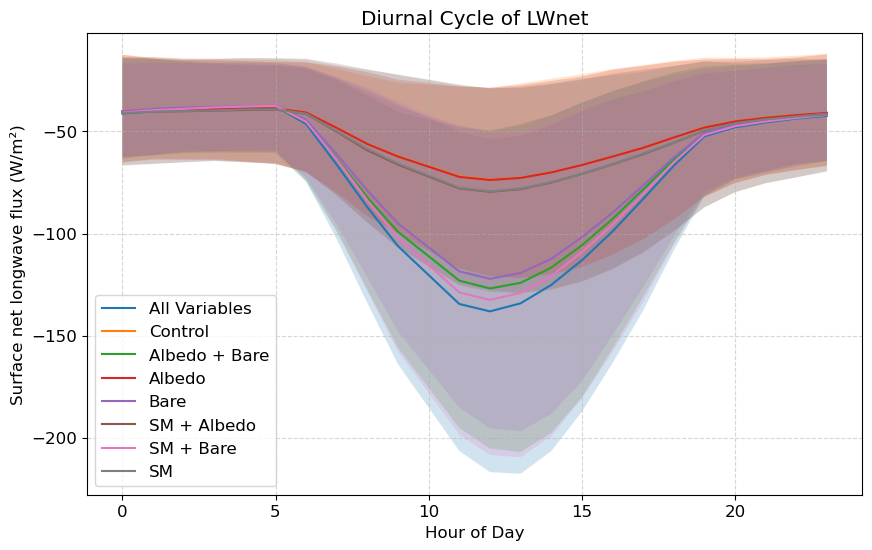

In [29]:
#diurnal
sw_diurnal = {}
for name, series in sw_series.items():
    grouped = series.groupby("time.hour")
    sw_diurnal[name] = {
        "mean": grouped.mean("time"),
        "p05": grouped.quantile(0.05, dim="time"),
        "p95": grouped.quantile(0.95, dim="time"),
    }

plt.figure(figsize=(10,6))

for name, stats in sw_diurnal.items():
    hours = stats["mean"]["hour"]

    #mean
    plt.plot(hours, stats["mean"].values, label=name)

    #5-95th %
    plt.fill_between(
        hours,
        stats["p05"].values,
        stats["p95"].values,
        alpha=0.2
    )

plt.title("Diurnal Cycle of LWnet")
plt.xlabel("Hour of Day")
plt.ylabel("Surface net longwave flux (W/m²)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()
